In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cat
from sklearn import linear_model as lm
from sklearn.preprocessing import SplineTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error


# Séries Temporais
No contexto de análise e ciência de dados, séries temporais são dados observados de forma sequencial, em intervalos regulares ou irregulares. Muitas vezes esses dados são resultado de agregações feitas por um campo de data: podemos construir a série temporal do número de itens vendidos pelo Olist por dia, ou então o número de ataques de tubarão for mês.

# Dataset

Vamos continuar a análise do conjunto de dados de cancelamentos de reservas em 2 hotéis europeus. No entanto, enquanto no case de sábado passado fizemos uma análise baseada no dado transacional (cada individuo de nossa tabela era uma reserva) hoje agregaremos este dado e analisaremos o resultado agregado diário para um dos hotéis.

Primeiro vamos carregar o conjunto de dados de hotéis e transformar a informação de data em campos datetime. Isso nos permitirá calcular a data na qual a reserva foi feita.

In [3]:
tb_hotel = pd.read_csv("data/tb_hotel_bookings_full.csv")
tb_hotel["arrival_dt"] = pd.to_datetime(tb_hotel["arrival_date"])
tb_hotel["update_dt"] = pd.to_datetime(tb_hotel["reservation_status_date"])
tb_hotel["reserva_dt"] = tb_hotel["arrival_dt"] - pd.to_timedelta(
    tb_hotel["lead_time"], unit="d"
)


Para construir a série temporal de cancelamentos e reservas precisamos decidir por qual campo de data agregaremos nossos dados:

1. **Data de Chegada**
1. **Data da Reserva**
1. **Data da Última Atualização da Reserva**

Essa opção é algo comum quando construímos séries temporais (no âmbito de produtos por exemplo podemos ver as datas de compra, de faturamento e de entrega por exemplo). Por enquanto limitaremos a análise à **data de chegada**.

In [4]:
tb_resort = tb_hotel[tb_hotel["hotel"] == "Resort Hotel"]
tb_resort_ts = (
    tb_resort.groupby("arrival_dt")
    .agg(
        num_reservas=pd.NamedAgg("id_booking", "count"),
        num_canceladas=pd.NamedAgg("is_canceled", "sum"),
    )
    .reset_index()
)
tb_resort_ts["per_canceladas"] = (
    tb_resort_ts["num_canceladas"] / tb_resort_ts["num_reservas"]
)


A forma mais comum de visualizar dados de série temporal é através de **lineplots** onde o tempo é colocado no eixo X e as variáveis a serem analisadas no eixo Y.

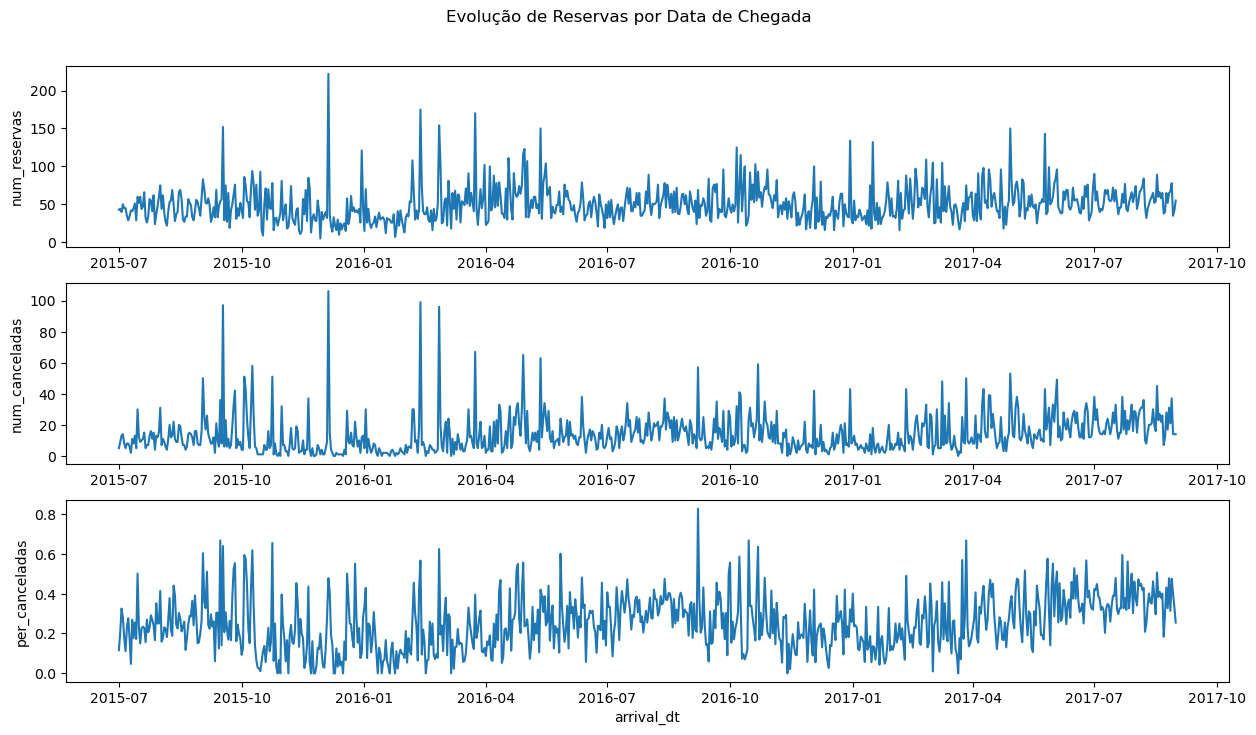

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="num_reservas", ax=ax[0])
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="num_canceladas", ax=ax[1])
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="per_canceladas", ax=ax[2])
ax[0].set_xlabel("")
ax[1].set_xlabel("")
fig.suptitle("Evolução de Reservas por Data de Chegada", y=0.95)


## Train & Test para séries temporais
A nossa estratégia tradicional para divisão de um dataset em train e test não funciona em séries temporais: como elas são definidas pela sequencialidade das observações, remover pontos aleatórios de dentro da série seria estranho... A forma mais simples e tradicional de se fazer essa divisão é selecionando pontos no fim da série como nosso conjunto teste. No exemplo acima optei por formar o conjunto de train a partir dos dois primeiros anos continuos que temos na série (veremos porque quando olharmos componentes sazonais).

In [6]:
tb_resort_ts["arrival_dt"].describe()


count                    793
mean     2016-07-31 00:00:00
min      2015-07-01 00:00:00
25%      2016-01-15 00:00:00
50%      2016-07-31 00:00:00
75%      2017-02-14 00:00:00
max      2017-08-31 00:00:00
Name: arrival_dt, dtype: object

Ao invés de realizar a transformação agora, vamos definir uma função que realiza essa divisão para nós. Dessa forma não precisamos replicar nosso feature engineering em 2 datasets o tempo todo.

In [7]:
def split_hotel_ts(hotel_data, break_date):
    train_data = hotel_data[hotel_data["arrival_dt"] < break_date].copy()
    test_data = hotel_data[hotel_data["arrival_dt"] >= break_date].copy()
    return train_data, test_data


# Decomposição TCSI

A forma mais tradicional de se analisar um série temporal é através da decomposição TCSI:

1. **T - Componente de Tendência (Trend):** representação da evolução a longo prazo da série (*a taxa de cancelamento está crescendo ou caindo?*)
1. **C - Componente Ciclico (Cyclic)** representação da evolução ciclica não periódicas (*tivemos momentos com mais (ou menos) cancelamentos de forma estrutural?*)
1. **S - Componente Sazonal (Seasonal)** representação da peridiocidade sazonal (ciclo regular) (*temos mais cancelamento para reservas em junho? ou para reservas de segunda-feira? ou da última semana do mês?*)
1. **I - Componente de Ruído (Irregular/Noise)** o que não é representado pelos três componentes acima.

## Componente de Tendência (Trend)

In [8]:
tb_resort_ts["t_dias"] = (
    tb_resort_ts["arrival_dt"] - min(tb_resort_ts["arrival_dt"])
).dt.total_seconds() / (24 * 60 * 60)
tb_resort_ts.head()

,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias
0,2015-07-01,43,5,0.116279,0.0
1,2015-07-02,44,9,0.204545,1.0
2,2015-07-03,40,13,0.325000,2.0
3,2015-07-04,50,14,0.280000,3.0
4,2015-07-05,45,8,0.177778,4.0


### Estimativa de tendência linear

In [9]:
train_data, test_data = split_hotel_ts(tb_resort_ts, "2017-08-01")
trend_fit = lm.LinearRegression()
trend_fit.fit(train_data[["t_dias"]], train_data["per_canceladas"])


LinearRegression()

In [10]:
trend_fit.coef_

array([0.00013428])

In [11]:
tb_resort_ts["pred_trend_linear"] = trend_fit.predict(tb_resort_ts[["t_dias"]])


Text(0.5, 0.95, 'Evolução de Reservas por Data de Chegada')

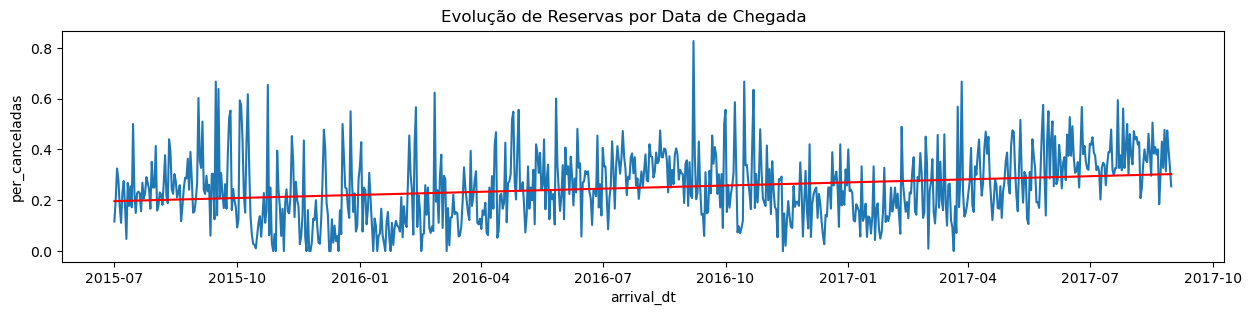

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="pred_trend_linear", color="red")
fig.suptitle("Evolução de Reservas por Data de Chegada", y=0.95)


## Componente Cíclico (Cycle)

Como os ciclos representam variações não-periódicas é dificil separa-los da avaliação de tendência (principalmente em séries curtas). Vamos utilizar três técnicas para estimar variações em relação a tendência.

### Tendência Polinomial

In [13]:
from sklearn.preprocessing import PolynomialFeatures


In [14]:
poly_trans = PolynomialFeatures(degree=2)
poly_trans.fit(train_data[["t_dias"]])


PolynomialFeatures()

In [15]:
poly_trans.n_output_features_


3

In [16]:
tb_resort_ts

,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear
0,2015-07-01,43,5,0.116279,0.0,0.196375
1,2015-07-02,44,9,0.204545,1.0,0.196509
2,2015-07-03,40,13,0.325000,2.0,0.196644
3,2015-07-04,50,14,0.280000,3.0,0.196778
4,2015-07-05,45,8,0.177778,4.0,0.196912
...,...,...,...,...,...,...
788,2017-08-27,67,21,0.313433,788.0,0.302185
789,2017-08-28,78,37,0.474359,789.0,0.302319
790,2017-08-29,35,14,0.400000,790.0,0.302453
791,2017-08-30,42,14,0.333333,791.0,0.302588


In [17]:
poly_names = ["P" + str(i) for i in range(poly_trans.n_output_features_)]
pd.DataFrame(
    poly_trans.transform(tb_resort_ts[["t_dias"]]),
    columns=poly_names,
)


,P0,P1,P2
0,1.0,0.0,0.0
1,1.0,1.0,1.0
2,1.0,2.0,4.0
3,1.0,3.0,9.0
4,1.0,4.0,16.0
...,...,...,...
788,1.0,788.0,620944.0
789,1.0,789.0,622521.0
790,1.0,790.0,624100.0
791,1.0,791.0,625681.0


In [18]:
poly_trans.transform(tb_resort_ts[["t_dias"]])

array([[1.00000e+00, 0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 2.00000e+00, 4.00000e+00],
       ...,
       [1.00000e+00, 7.90000e+02, 6.24100e+05],
       [1.00000e+00, 7.91000e+02, 6.25681e+05],
       [1.00000e+00, 7.92000e+02, 6.27264e+05]])

In [19]:
poly_names = ["P" + str(i) for i in range(poly_trans.n_output_features_)]
tb_resort_ts_p = pd.concat(
    [
        tb_resort_ts,
        pd.DataFrame(
            poly_trans.transform(tb_resort_ts[["t_dias"]]),
            columns=poly_names,
        ),
    ],
    axis=1,
)
tb_resort_ts_p.head()


,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear,P0,P1,P2
0,2015-07-01,43,5,0.116279,0.0,0.196375,1.0,0.0,0.0
1,2015-07-02,44,9,0.204545,1.0,0.196509,1.0,1.0,1.0
2,2015-07-03,40,13,0.325000,2.0,0.196644,1.0,2.0,4.0
3,2015-07-04,50,14,0.280000,3.0,0.196778,1.0,3.0,9.0
4,2015-07-05,45,8,0.177778,4.0,0.196912,1.0,4.0,16.0


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau 2')

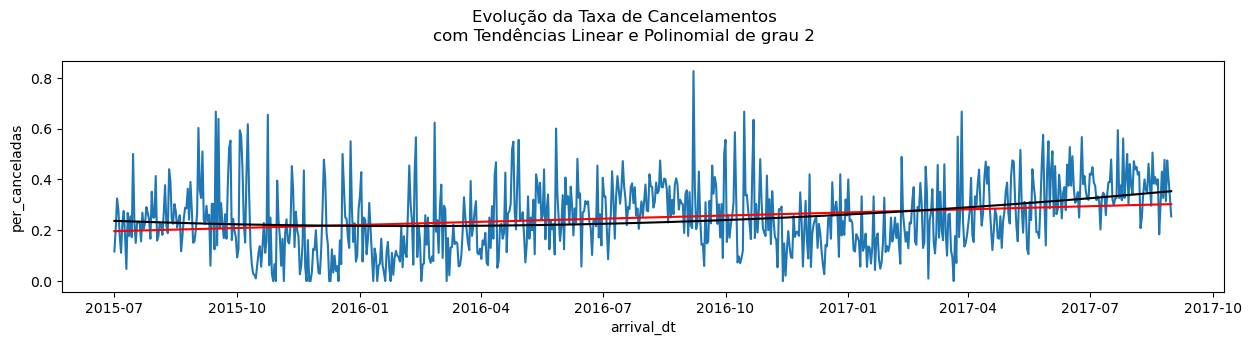

In [20]:
train_data, test_data = split_hotel_ts(tb_resort_ts_p, "2017-08-01")

poly_trend_fit = lm.LinearRegression()
poly_trend_fit.fit(train_data[poly_names], train_data["per_canceladas"])


tb_resort_ts_p["pred_trend_poly"] = poly_trend_fit.predict(tb_resort_ts_p[poly_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="pred_trend_poly", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau {poly_trans.degree}",
    y=1.05,
)


In [21]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_poly"] = poly_trend_fit.predict(test_data[poly_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_poly = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_poly"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Poly.: {round(rmse_poly, 2)}")


Trend Lin.: 0.11
Trend Poly.: 0.08


### B-Splines

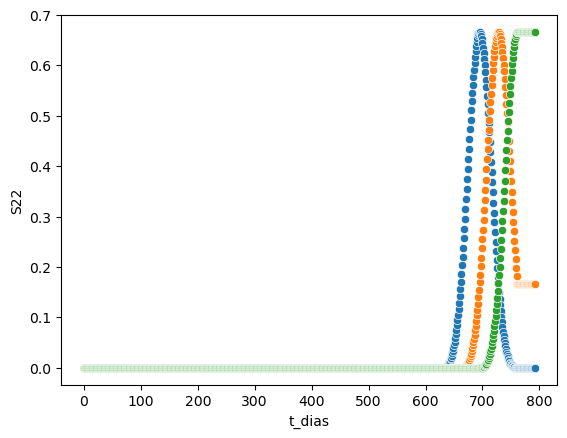

In [22]:
spl_trans = SplineTransformer(n_knots=24, extrapolation="constant")
spl_trans.fit(train_data[["t_dias"]])
spl_names = ["S" + str(i) for i in range(spl_trans.n_features_out_)]
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts,
        pd.DataFrame(
            spl_trans.transform(tb_resort_ts[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)
tb_resort_ts_b.head()
sns.scatterplot(data=tb_resort_ts_b, x="t_dias", y="S22")
sns.scatterplot(data=tb_resort_ts_b, x="t_dias", y="S23")
sns.scatterplot(data=tb_resort_ts_b, x="t_dias", y="S24")


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines')

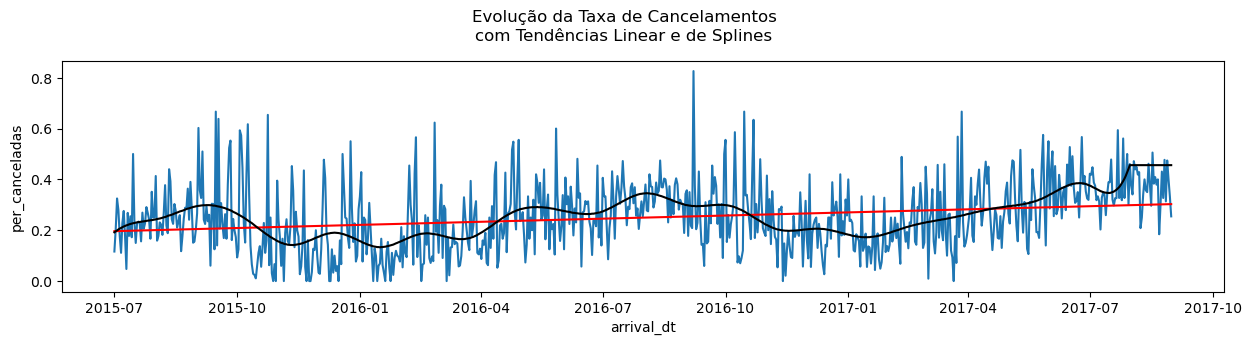

In [23]:
train_data, test_data = split_hotel_ts(tb_resort_ts_b, "2017-08-01")
spline_fit = lm.LinearRegression()
spline_fit.fit(train_data[spl_names], train_data["per_canceladas"])
tb_resort_ts_b["pred_spline"] = spline_fit.predict(tb_resort_ts_b[spl_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines",
    y=1.05,
)


In [24]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spl = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline: {round(rmse_spl, 2)}")


Trend Lin.: 0.11
Trend Spline: 0.11


O que podemos melhorar aqui?

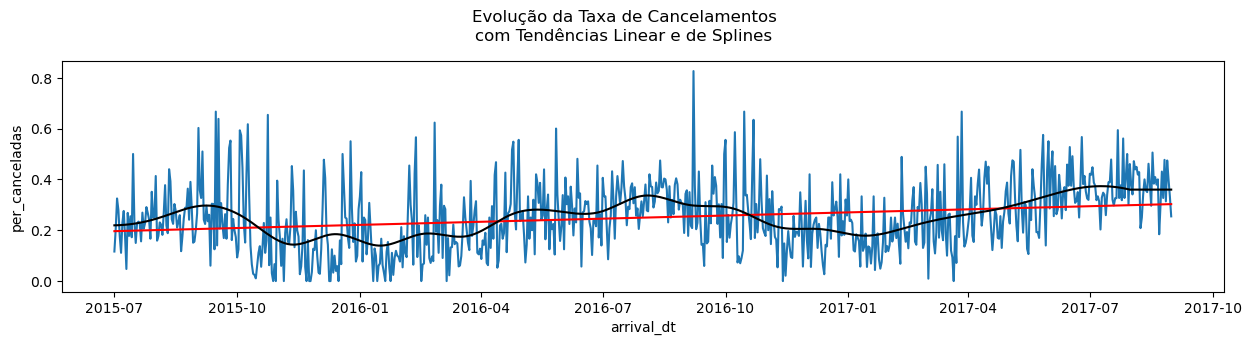

In [25]:
train_data, test_data = split_hotel_ts(tb_resort_ts_b, "2017-08-01")
spline_fit = lm.RidgeCV(cv=5)
spline_fit.fit(train_data[spl_names], train_data["per_canceladas"])
tb_resort_ts_b["pred_spline"] = spline_fit.predict(tb_resort_ts_b[spl_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines",
    y=1.05,
)


In [26]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spl = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline.: {round(rmse_spl, 2)}")


Trend Lin.: 0.11
Trend Spline.: 0.08


## Componente Sazonal

### Variáveis Sazonais Dummy

In [27]:
tb_resort_ts_b["mes"] = tb_resort_ts_b["arrival_dt"].dt.month.astype(str)
tb_resort_ts_b["dia_semana"] = tb_resort_ts_b["arrival_dt"].dt.weekday.astype(str)


In [28]:
tb_resort_ts_b[["mes", "dia_semana"]]


,mes,dia_semana
0,7,2
1,7,3
2,7,4
3,7,5
4,7,6
...,...,...
788,8,6
789,8,0
790,8,1
791,8,2


In [29]:
ohe_fit = OneHotEncoder(drop="first", sparse=False)
ohe_fit.fit(tb_resort_ts_b[["mes", "dia_semana"]])
tb_resort_ts_d = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            ohe_fit.transform(tb_resort_ts_b[["mes", "dia_semana"]]),
            columns=ohe_fit.get_feature_names_out(),
        ),
    ],
    axis=1,
)


/Users/pedroteche/miniconda3/envs/timeseries/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [30]:
tb_resort_ts_d.head()


,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear,S0,S1,S2,S3,...,mes_6,mes_7,mes_8,mes_9,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
0,2015-07-01,43,5,0.116279,0.0,0.196375,0.166667,0.666667,0.166667,0.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2015-07-02,44,9,0.204545,1.0,0.196509,0.152007,0.665767,0.182221,0.000005,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2015-07-03,40,13,0.325000,2.0,0.196644,0.138233,0.663123,0.198607,0.000037,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2015-07-04,50,14,0.280000,3.0,0.196778,0.125318,0.658818,0.215740,0.000124,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2015-07-05,45,8,0.177778,4.0,0.196912,0.113233,0.652935,0.233538,0.000294,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais')

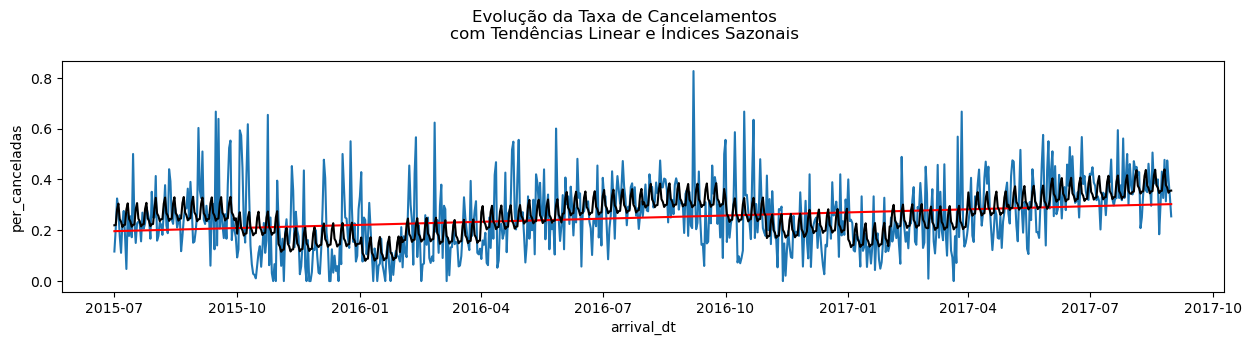

In [31]:
train_data, test_data = split_hotel_ts(tb_resort_ts_d, "2017-08-01")
dummy_names = list(ohe_fit.get_feature_names_out())
var_names = ["t_dias"] + dummy_names
season_trend_fit = lm.LinearRegression()
season_trend_fit.fit(train_data[var_names], train_data["per_canceladas"])

tb_resort_ts_d["pred_trend_season"] = season_trend_fit.predict(
    tb_resort_ts_d[var_names]
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_trend_season", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais')

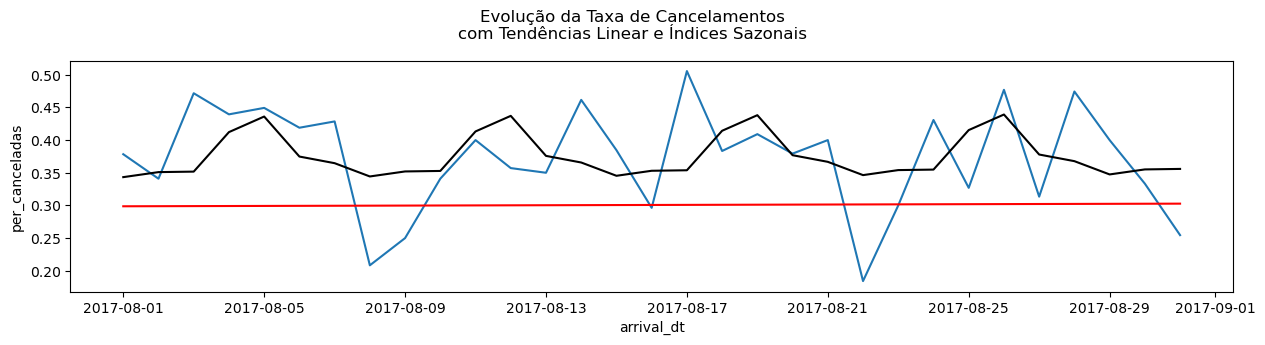

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(
    data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] >= "2017-08-01"],
    x="arrival_dt",
    y="per_canceladas",
)
sns.lineplot(
    data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] >= "2017-08-01"],
    x="arrival_dt",
    y="pred_trend_linear",
    color="red",
)
sns.lineplot(
    data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] >= "2017-08-01"],
    x="arrival_dt",
    y="pred_trend_season",
    color="black",
)
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)


In [33]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_season"] = season_trend_fit.predict(test_data[var_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_cycle = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_season"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend + Season: {round(rmse_cycle, 2)}")


Trend Lin.: 0.11
Trend + Season: 0.07


# Criando nosso modelo final

In [34]:
final_list = spl_names + dummy_names + ["t_dias"]
X_train = train_data[final_list]
X_test = test_data[final_list]
y_train = train_data["per_canceladas"]
y_test = test_data["per_canceladas"]
scaler = StandardScaler()
scaler.fit(X_train)

cat_fit = cat.CatBoostRegressor(
    iterations=20000, depth=9, od_type="Iter", od_wait=1500, verbose=False
)
cat_fit.fit(
    scaler.transform(X_train), y_train, eval_set=(scaler.transform(X_test), y_test)
)


Trend Lin.: 0.11
Trend Spline.: 0.08
Trend+Sazonal: 0.07
Trend+Spline+Seazonal: 0.08


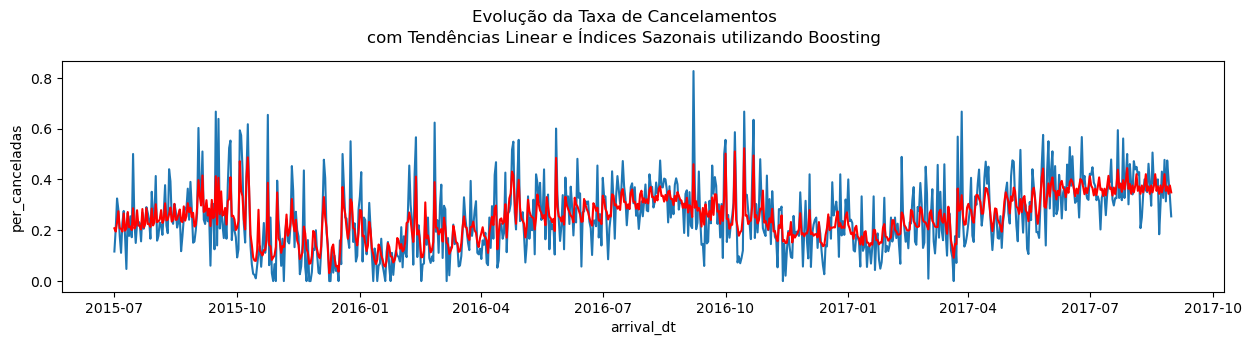

In [35]:
tb_resort_ts_d["pred_boosting"] = cat_fit.predict(
    scaler.transform(tb_resort_ts_d[final_list])
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_boosting", color="red")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais utilizando Boosting",
    y=1.05,
)

pred_boosting = cat_fit.predict(scaler.transform(X_test[final_list]))
rmse_cat = np.sqrt(mean_squared_error(y_test, pred_boosting))
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline.: {round(rmse_spl, 2)}")
print(f"Trend+Sazonal: {round(rmse_cycle, 2)}")
print(f"Trend+Spline+Seazonal: {round(rmse_cat, 2)}")


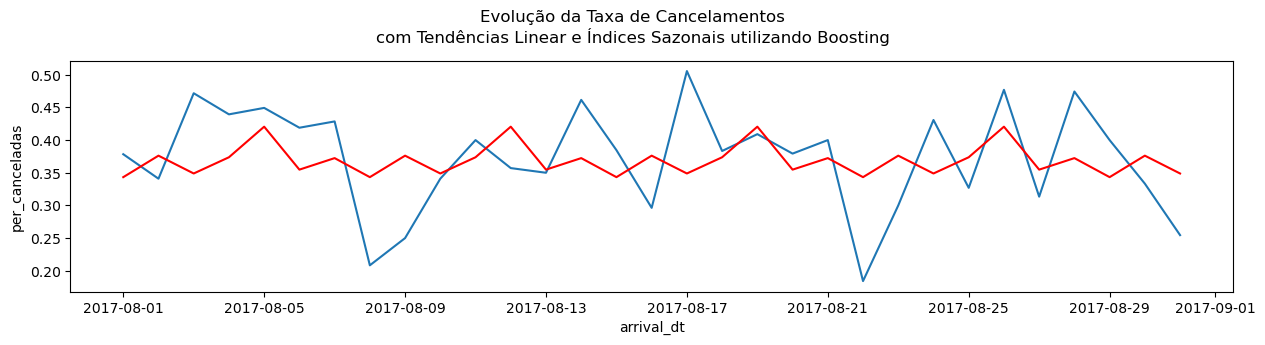

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(
    data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] >= "2017-08-01"],
    x="arrival_dt",
    y="per_canceladas",
)
sns.lineplot(
    data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] >= "2017-08-01"],
    x="arrival_dt",
    y="pred_boosting",
    color="red",
)
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais utilizando Boosting",
    y=1.05,
)


In [37]:
len(pred_boosting)

31

# Processos Auto-regressivos

**Introdução aos Modelos Auto-regressivos para Estudantes Não-STEM**

Os modelos auto-regressivos são um tipo de modelo estatístico especialmente útil para analisar e prever padrões em dados sequenciais. Esse tipo de dado é caracterizado por sua natureza temporal ou sequencial, onde as observações são coletadas ao longo do tempo e ordenadas em uma sequência específica. Exemplos de dados sequenciais incluem:

- Preços de ações
- Medidas climáticas
- Sequências de linguagem
- Indicadores econômicos

A ideia principal por trás dos modelos auto-regressivos é aproveitar as informações das observações anteriores para fazer previsões sobre valores futuros. Em outras palavras, esses modelos levam em consideração a relação entre observações atuais e passadas para estimar o que pode acontecer a seguir. Isso os torna adequados para tarefas como:

- Previsão de séries temporais
- Previsão de valores futuros com base em dados históricos

Os modelos auto-regressivos se baseiam na suposição de que os valores futuros de uma sequência dependem linearmente de seus valores passados. Isso significa que o modelo estima o valor atual combinando uma soma ponderada de observações anteriores, em que os pesos representam a importância ou contribuição de cada observação passada. O número de observações passadas usadas para a previsão é frequentemente chamado de "ordem" do modelo.

Para ilustrar isso, vamos considerar um exemplo simples. Suponha que tenhamos um conjunto de dados de séries temporais com medidas diárias de temperatura. Podemos usar um modelo auto-regressivo para prever a temperatura de amanhã com base nas temperaturas dos dias anteriores. Ao analisar os padrões e relacionamentos nos dados históricos, o modelo pode estimar a temperatura para o próximo dia.

Os modelos auto-regressivos existem em várias formas, sendo o mais comum o **modelo Auto-Regressivo (AR)**. Outras variações incluem o **modelo de Médias Móveis (MA)** e o **modelo Auto-Regressivo de Médias Móveis (ARMA)**. Além disso, modelos mais avançados, como o **modelo Auto-Regressivo Integrado de Médias Móveis (ARIMA)** e suas extensões, incorporam técnicas de diferenciação e integração para lidar com dados não estacionários.

Embora os modelos auto-regressivos tenham suas raízes na estatística, eles encontraram aplicações em diversos campos além da matemática. Por exemplo:

- Economistas utilizam esses modelos para prever tendências no mercado financeiro
- Engenheiros os utilizam para processamento de sinais
- Pesquisadores de processamento de linguagem natural os empregam para geração de linguagem e tradução automática


## Auto-correlação e Autocorrelação Parcial

**Auto-correlação:**
A *auto-correlação* é uma medida estatística que descreve o grau de dependência entre observações em uma série temporal. Ela quantifica a relação entre uma observação atual e as observações anteriores em diferentes defasagens. Em outras palavras, a auto-correlação indica se há uma relação linear entre os valores de uma série temporal em diferentes momentos no tempo. Uma autocorrelação positiva indica uma relação positiva entre os valores, enquanto uma autocorrelação negativa indica uma relação negativa. A auto-correlação é comumente usada para identificar:

- Padrões sazonais
- Tendências
- Ciclos em séries temporais.

**Auto-correlação parcial:**
A *auto-correlação parcial* é uma medida estatística que mede a relação entre duas observações em uma série temporal, controlando o efeito das observações intermediárias. Em outras palavras, a auto-correlação parcial indica a correlação entre uma observação e outra observação anterior, removendo o efeito das observações intermediárias. Ela ajuda a identificar a contribuição específica de cada observação passada para a relação com a observação atual. A auto-correlação parcial é útil na modelagem de séries temporais, especialmente na identificação da ordem adequada de um modelo auto-regressivo (AR) ao analisar dados sequenciais.

Ambas a auto-correlação e a auto-correlação parcial são ferramentas estatísticas essenciais na análise de séries temporais e na construção de modelos auto-regressivos. Elas fornecem informações sobre as relações de dependência entre as observações, ajudando a compreender a estrutura subjacente dos dados e a escolher a abordagem correta de modelagem para fazer previsões precisas.

Text(0.5, 1.05, 'Evolução do Número de Reservas')

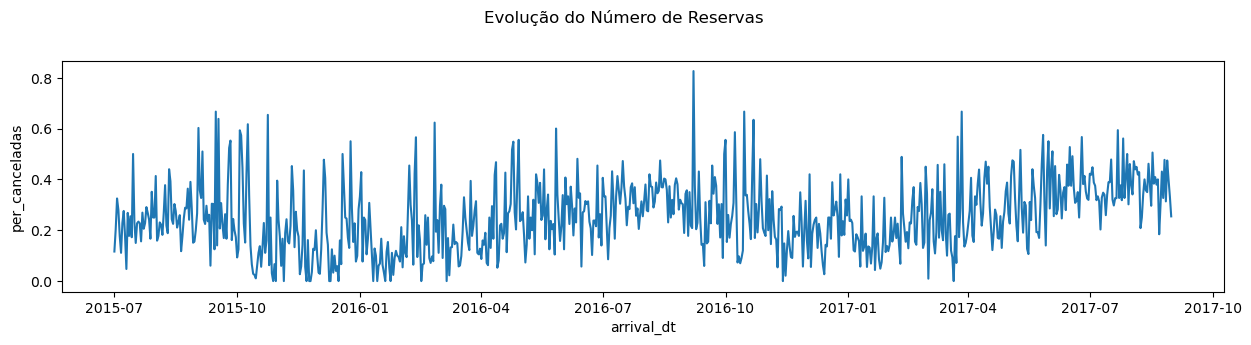

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
fig.suptitle(
    f"Evolução do Número de Reservas",
    y=1.05,
)


O método `.shift()` retorna uma série *atrasada* (ou *adiantada*) em relação a série original:

In [39]:
tb_resort_ts_d["per_canceladas_lag"] = tb_resort_ts_d["per_canceladas"].shift(1)
tb_resort_ts_d[["per_canceladas", "per_canceladas_lag"]].head()


,per_canceladas,per_canceladas_lag
0,0.116279,NaN
1,0.204545,0.116279
2,0.325000,0.204545
3,0.280000,0.325000
4,0.177778,0.280000


Com esta nova coluna (`per_canceladas_lag`) podemos **visualizar** a auto-correlação (no horizonte de 1 dia) da série `per_canceladas`: a auto-correlação é a correlação de uma série temporal com seu **passado**!

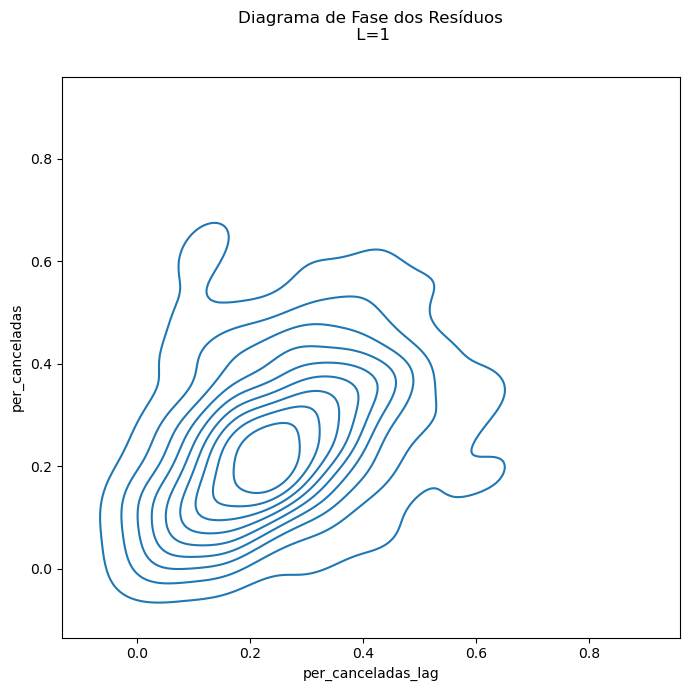

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.kdeplot(
    data=tb_resort_ts_d,
    x="per_canceladas_lag",
    y="per_canceladas",
)
ax.set_title(f"Diagrama de Fase dos Resíduos\n L=1", y=1.05)
fig.tight_layout()


O diagrama de fase nos permite visualizar de forma simples a correlação para alguns (no caso acima um) período de lag - mas podemos ter autocorrelação em diversos atrasos (especialmente se nossa série tem sazonalidade).

Temos duas ferramentas disponíveis para entender a estrutura de auto-correlação de uma série temporal: a ACF e a PACF.

In [41]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

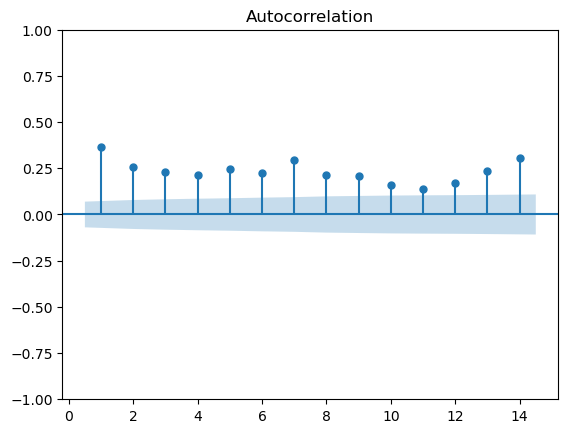

In [42]:
plot_acf(tb_resort_ts_d["per_canceladas"], lags=range(1, 15))


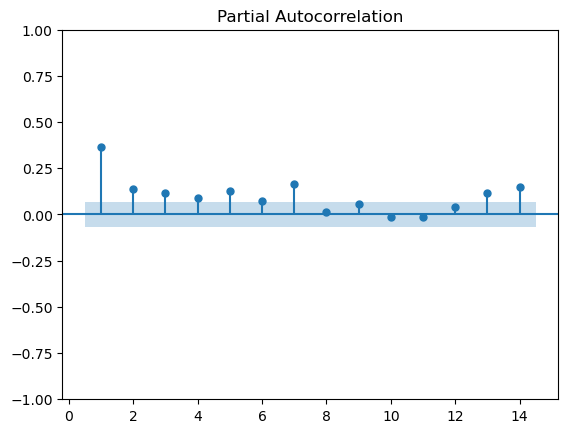

In [43]:
plot_pacf(tb_resort_ts_d["per_canceladas"], lags=range(1, 15), method="ywm")


A questão da inter-dependencia das observações é crítica em séries temporais - nossos modelos anteriores assumiam que as observações eram independentes entre si, o que não é o caso em séries temporais. Vamos ver se o erro do nosso modelo acima tinha autocorrelação:

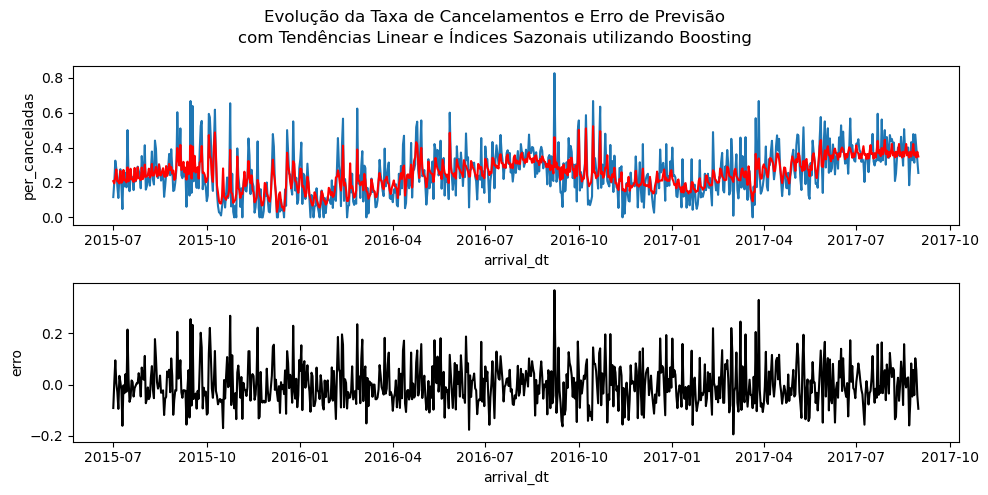

In [44]:
tb_resort_ts_d["erro"] = (
    tb_resort_ts_d["per_canceladas"] - tb_resort_ts_d["pred_boosting"]
)

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas", ax=ax[0])
sns.lineplot(
    data=tb_resort_ts_d, x="arrival_dt", y="pred_boosting", color="red", ax=ax[0]
)
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="erro", color="black", ax=ax[1])

fig.suptitle(
    f"Evolução da Taxa de Cancelamentos e Erro de Previsão\ncom Tendências Linear e Índices Sazonais utilizando Boosting"
)
fig.tight_layout()


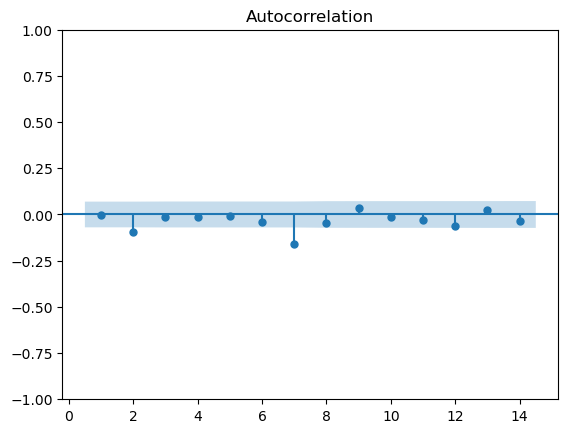

In [45]:
plot_acf(tb_resort_ts_d["erro"], lags=range(1, 15))


Qualquer autocorrelação que exista no **erro** do modelo é informação *jogada fora*: poderíamos incorporar essa informação no modelo e melhorar nossa previsão. Mas como podemos fazer isso?

A forma *naive* seria utilizando o método `.shift()` para gerar uma série de lags da série temporal e incorporar essas variáveis no modelo. No entanto, isso tornará muito dificíl fazer previsões: para prever um horizonte maior que 1, precisaríamos da projeção no dia anterior!

Vamos utilizar a biblioteca `scalecast` para criar um workflow de trabalho com séries temporais:

In [48]:
from scalecast.Forecaster import Forecaster

O objeto central da biblioteca `scalecast` é o Forecast - ele age como uma combinação de `DataFrame` com `pipeline`:

In [ ]:
tb_resort_ts_d["arrival_dt"]

In [64]:
f = Forecaster(
    y=tb_resort_ts_d["per_canceladas"],  # Nossa séries temporal
    current_dates=tb_resort_ts_d["arrival_dt"],  # Datas associadas à nossa série temporal
    future_dates=24,  # Comprimento do horizonte de forecast
    test_length=90,  # Comprimento do conjunto de teste
    metrics=["rmse"],  # Métrica de avaliação do nosso modelo
)


Podemos utilizar o método `.plot()` para visualizar nossa série temporal em nosso `Forecaster`:

<Axes: xlabel='Date', ylabel='Values'>

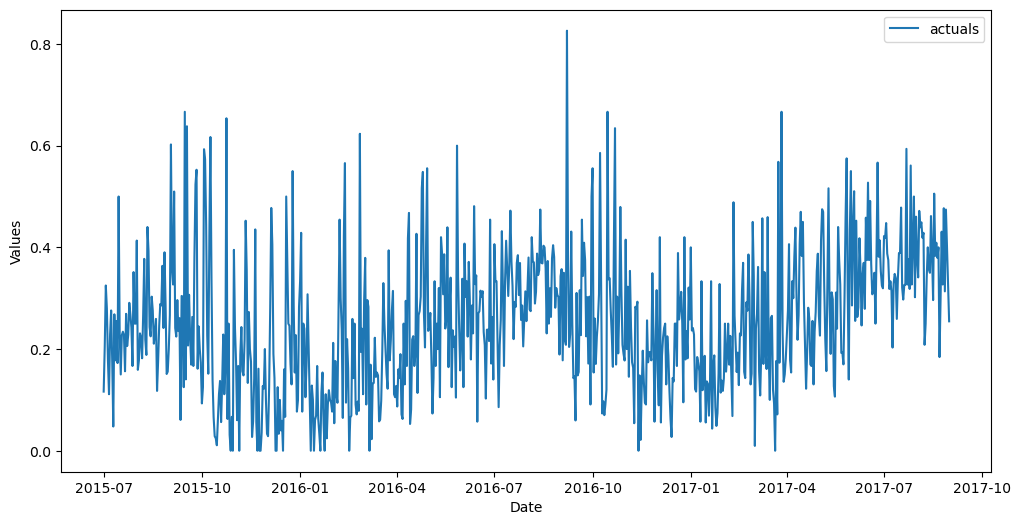

In [65]:
f.plot()

Agora, vamos utilizar métodos de nosso Forecaster para especificar nosso modelo:

In [66]:
f.add_time_trend() # Tendencia linear
f.add_seasonal_regressors("month", raw = False, dummy = True, drop_first = True) # Sazonalidade mensal
f.add_seasonal_regressors('dayofweek', raw=False, dummy=True, drop_first=True) # Sazonalidade do dia da semana

Para adicionar nossos termos autoregressivos utilizamos o método `.add_ar_terms()`:

In [67]:
f.add_ar_terms(7) # Termos autorregressivos (7)

In [68]:
f.eval_cis(
    mode = True, # tell the object to evaluate intervals
    cilevel = .95, # 95% confidence level
)

In [69]:
f.set_estimator('mlr')
f.manual_forecast(dynamic_testing=90)

In [72]:
f.set_estimator('catboost')
f.manual_forecast(iterations = 1000, max_depth = 10)

Learning rate set to 0.038664
0:	learn: 0.1334091	total: 21.3ms	remaining: 21.2s
1:	learn: 0.1323597	total: 27.7ms	remaining: 13.8s
2:	learn: 0.1312780	total: 35ms	remaining: 11.6s
3:	learn: 0.1300051	total: 45.7ms	remaining: 11.4s
4:	learn: 0.1290215	total: 54.6ms	remaining: 10.9s
5:	learn: 0.1279576	total: 60.3ms	remaining: 9.99s
6:	learn: 0.1270386	total: 66ms	remaining: 9.36s
7:	learn: 0.1259437	total: 70.7ms	remaining: 8.76s
8:	learn: 0.1249218	total: 75.4ms	remaining: 8.3s
9:	learn: 0.1240594	total: 79.8ms	remaining: 7.9s
10:	learn: 0.1231127	total: 85.8ms	remaining: 7.72s
11:	learn: 0.1223859	total: 92.1ms	remaining: 7.59s
12:	learn: 0.1214999	total: 98.2ms	remaining: 7.45s
13:	learn: 0.1207265	total: 103ms	remaining: 7.26s
14:	learn: 0.1197678	total: 107ms	remaining: 7.05s
15:	learn: 0.1189671	total: 112ms	remaining: 6.88s
16:	learn: 0.1183268	total: 117ms	remaining: 6.76s
17:	learn: 0.1174662	total: 121ms	remaining: 6.62s
18:	learn: 0.1166784	total: 126ms	remaining: 6.5s
19:	l

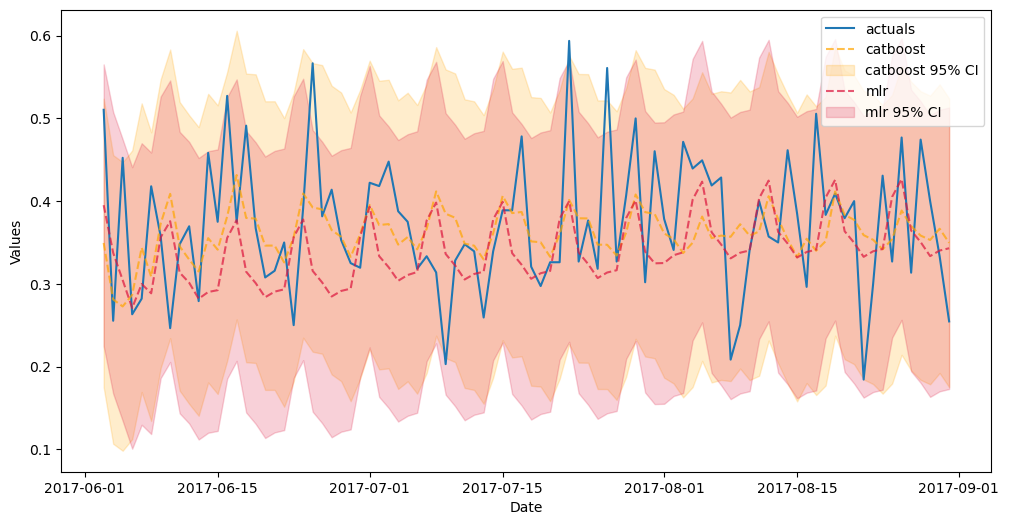

In [75]:
f.plot_test_set(ci=True,models=['mlr','catboost'],order_by='TestSetRMSE', include_train = False)
plt.show()

In [87]:
results = f.export(cis=True, models =['catboost', 'mlr'])

In [88]:
results['model_summaries']

,ModelNickname,Estimator,Xvars,HyperParams,Observations,DynamicallyTested,TestSetLength,CILevel,ValidationMetric,ValidationMetricValue,models,weights,best_model,InSampleRMSE,TestSetRMSE
0,catboost,catboost,"[t, month_10, month_11, month_12, month_2, mon...","{'iterations': 1000, 'max_depth': 10}",793,1,90,0.95,NaN,NaN,NaN,NaN,False,0.005283,0.081408
1,mlr,mlr,"[t, month_10, month_11, month_12, month_2, mon...",{},793,90,90,0.95,NaN,NaN,NaN,NaN,True,0.113065,0.088192


In [90]:
results['lvl_fcsts']

,DATE,catboost,catboost_upperci,catboost_lowerci,mlr,mlr_upperci,mlr_lowerci
0,2017-09-01,0.344369,0.518858,0.169880,0.252753,0.422942,0.082564
1,2017-09-02,0.418025,0.592514,0.243536,0.280103,0.450292,0.109914
2,2017-09-03,0.367570,0.542059,0.193081,0.200698,0.370888,0.030509
3,2017-09-04,0.401756,0.576245,0.227267,0.193595,0.363784,0.023405
4,2017-09-05,0.339748,0.514237,0.165259,0.166565,0.336754,-0.003624
5,2017-09-06,0.375976,0.550465,0.201487,0.174276,0.344465,0.004087
6,2017-09-07,0.315941,0.490430,0.141452,0.179125,0.349314,0.008936
7,2017-09-08,0.409324,0.583813,0.234835,0.233315,0.403504,0.063125
8,2017-09-09,0.427056,0.601545,0.252567,0.259023,0.429213,0.088834
9,2017-09-10,0.359722,0.534211,0.185234,0.197494,0.367684,0.027305


# Apêndice

### Variáveis Sazonais Contínuas

In [ ]:
tb_resort_ts_b["s_semana"] = np.sin(tb_resort_ts_b["t_dias"] / (7 / np.pi))
tb_resort_ts_b["c_semana"] = np.cos(tb_resort_ts_b["t_dias"] / (7 / np.pi))

tb_resort_ts_b["s_mes"] = np.sin(tb_resort_ts_b["t_dias"] / (30.4 / np.pi))
tb_resort_ts_b["c_mes"] = np.cos(tb_resort_ts_b["t_dias"] / (30.4 / np.pi))

tb_resort_ts_b["s_ano"] = np.sin(tb_resort_ts_b["t_dias"] / (365 / np.pi))
tb_resort_ts_b["c_ano"] = np.cos(tb_resort_ts_b["t_dias"] / (365 / np.pi))


In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_semana", ax=ax[0])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_semana", ax=ax[0])

sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_mes", ax=ax[1])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_mes", ax=ax[1])

sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_ano", ax=ax[2])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_ano", ax=ax[2])

ax[0].set_xlabel("")
ax[1].set_xlabel("")
fig.suptitle("Variáveis Contínuas Ciclicas", y=0.95)


In [ ]:
c_names = ["c_semana", "s_semana", "c_mes", "s_mes", "c_ano", "s_ano"]
spl_cycle = spl_names + c_names
train_data, test_data = split_hotel_ts(tb_resort_ts_b)
spl_cycle_fit = lm.Ridge()
spl_cycle_fit.fit(train_data[spl_cycle], train_data["per_canceladas"])
tb_resort_ts_b["pred_cycle_poly"] = spl_cycle_fit.predict(tb_resort_ts_b[spl_cycle])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_cycle_poly", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau {poly_trans.degree}",
    y=1.05,
)


In [ ]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
test_data["pred_trend_cycle"] = spl_cycle_fit.predict(test_data[spl_cycle])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spline = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
rmse_cycle = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_cycle"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Poly.: {round(rmse_spline, 2)}")
print(f"Trend + Cycle: {round(rmse_cycle, 2)}")


## Fazendo previsões

In [ ]:
tb_resort_ts_b = tb_resort_ts.copy()
tb_resort_ts_b["mes"] = tb_resort_ts_b["arrival_dt"].dt.month.astype(str)
tb_resort_ts_b["dia_semana"] = tb_resort_ts_b["arrival_dt"].dt.weekday.astype(str)

ohe_fit = OneHotEncoder(drop="first", sparse=False)
ohe_fit.fit(tb_resort_ts_b[["mes", "dia_semana"]])
dummy_names = list(ohe_fit.get_feature_names_out())
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            ohe_fit.transform(tb_resort_ts_b[["mes", "dia_semana"]]),
            columns=dummy_names,
        ),
    ],
    axis=1,
)

spl_trans = SplineTransformer(n_knots=24, extrapolation="constant")
spl_trans.fit(tb_resort_ts_b[["t_dias"]])
spl_names = ["S" + str(i) for i in range(spl_trans.n_features_out_)]
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            spl_trans.transform(tb_resort_ts_b[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)

final_list = spl_names + dummy_names + ["t_dias"]
X = tb_resort_ts_b[final_list]
y = tb_resort_ts_b["num_reservas"]
scaler = StandardScaler()
scaler.fit(X)
cat_fit = cat.CatBoostRegressor(iterations=1708, depth=9)
cat_fit.fit(scaler.transform(X), y)


In [ ]:
X_pred = range(int(max(X["t_dias"])), int(max(X["t_dias"])) + 31)
min_date = min(tb_resort_ts_b["arrival_dt"])
tb_pred = pd.DataFrame({"t_dias": X_pred})
tb_pred["arrival_dt"] = pd.to_timedelta(tb_pred["t_dias"], "d") + min_date


In [ ]:
tb_pred

In [ ]:
X_pred = range(int(max(X["t_dias"])), int(max(X["t_dias"])) + 31)
min_date = min(tb_resort_ts_b["arrival_dt"])
tb_pred = pd.DataFrame({"t_dias": X_pred})
tb_pred["arrival_dt"] = pd.to_timedelta(tb_pred["t_dias"], "d") + min_date
tb_pred["mes"] = tb_pred["arrival_dt"].dt.month.astype(str)
tb_pred["dia_semana"] = tb_pred["arrival_dt"].dt.weekday.astype(str)

tb_pred = pd.concat(
    [
        tb_pred,
        pd.DataFrame(
            ohe_fit.transform(tb_pred[["mes", "dia_semana"]]),
            columns=dummy_names,
        ),
    ],
    axis=1,
)

tb_pred = pd.concat(
    [
        tb_pred,
        pd.DataFrame(
            spl_trans.transform(tb_pred[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)


In [ ]:
tb_pred

In [ ]:
tb_pred["pred"] = cat_fit.predict(scaler.transform(tb_pred[final_list]))


In [ ]:
tb_pred["lim_inf_cancelamento"] = tb_pred["pred"] - 0.076
tb_pred["lim_sup_cancelamento"] = tb_pred["pred"] + 0.076


In [ ]:
tb_pred[["arrival_dt", "pred", "lim_inf_cancelamento", "lim_sup_cancelamento"]]
